In [207]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd
import torch.optim as optim
import cv2
import optuna
from optuna.trial import Trial

In [208]:
config = {
    'data_dir': './datasets/train_zip/train',
    'data_test_dir': './datasets/test_zip/test',
    'class_mapping': {'apple': 0, 'banana': 1, 'orange': 2},
    'class_mapping_num': {0: 'apple', 1: 'banana', 2: 'orange'}  
}

In [209]:
data = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}
data_test = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

In [210]:
def get_file_image_dimensions(file_path):
    if not os.path.isfile(file_path):
        return None, None
    with Image.open(file_path) as img:
        width, height = img.size
    return width, height

def get_xml_image_dimensions(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    if size is not None:
        width = size.find('width').text
        height = size.find('height').text
        if width and height:
            return int(width), int(height)
    return 0, 0  


def get_image_dimensions(xml_file, image_file_path):
    width, height = get_xml_image_dimensions(xml_file)
    
    if width == 0 or height == 0:
        width, height = get_file_image_dimensions(image_file_path)
        
    return width, height


def parse_xml(xml_file, image_file_path, dataframe):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    
    width, height = get_image_dimensions(xml_file, image_file_path)

    for obj in root.iter('object'):
        obj_class = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        dataframe['filename'].append(filename)
        dataframe['width'].append(width)
        dataframe['height'].append(height)
        dataframe['class'].append(obj_class)
        dataframe['xmin'].append(xmin)
        dataframe['ymin'].append(ymin)
        dataframe['xmax'].append(xmax)
        dataframe['ymax'].append(ymax)

In [211]:
def fill_dataframe(dataframe, data_dir):
    images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    for image_file in images:
        xml_file = image_file.replace('.jpg', '.xml')
        xml_path = os.path.join(data_dir, xml_file)
        image_path = os.path.join(data_dir, image_file)
        if os.path.exists(xml_path):
            parse_xml(xml_path, image_path, dataframe)

fill_dataframe(data, config['data_dir'])
fill_dataframe(data_test, config['data_test_dir'])

In [212]:
train_df = pd.DataFrame(data)
test_df = pd.DataFrame(data_test)

In [213]:
def transform_data(df):
    transformed_data = []

    for filename, group in df.groupby('filename'):
        data = {
            'filename': filename,
            'width': group['width'].iloc[0],
            'height': group['height'].iloc[0],
            'objects': []
        }

        for _, row in group.iterrows():
            data['objects'].append({
                'class': row['class'],
                'xmin': row['xmin'],
                'ymin': row['ymin'],
                'xmax': row['xmax'],
                'ymax': row['ymax']
            })
        
        transformed_data.append(data)

    return transformed_data

In [214]:
train_df = transform_data(train_df)
test_df = transform_data(test_df)

In [215]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [216]:
class FruitDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, image_size=(224, 224), num_anchors=9):
        self.data_dir = data_dir
        self.transforms = transforms
        self.image_size = image_size
        self.dataframe = df
        self.num_anchors = num_anchors

    def __len__(self):
        return len(self.dataframe)
    
    def class_to_label(self, class_name):
        class_mapping = {'apple': 0, 'banana': 1, 'orange': 2}  
        return class_mapping.get(class_name, 0) 
    
    def pad_bboxes_and_labels(self, bboxes, labels):
        num_boxes = bboxes.size(0)
        if num_boxes > self.num_anchors:
            bboxes = bboxes[:self.num_anchors]
            labels = labels[:self.num_anchors]
        else:
            padding_bboxes = torch.zeros((self.num_anchors - num_boxes, 4), dtype=bboxes.dtype)
            padding_labels = torch.zeros((self.num_anchors - num_boxes,), dtype=labels.dtype)
            bboxes = torch.cat([bboxes, padding_bboxes], dim=0)
            labels = torch.cat([labels, padding_labels], dim=0)
        return bboxes, labels

    def __getitem__(self, idx):
        obj = self.dataframe[idx]
        file_name = obj['filename']
        image_path = os.path.join(self.data_dir, file_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = image.resize(self.image_size)
        
        bboxes = []
        labels = []
        objects = obj['objects']
        for obj in objects:
            class_name = obj['class']
            label = self.class_to_label(class_name)
            labels.append(label)
            
            bbox = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']]
            bboxes.append(bbox)
        
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        # Apply padding to match num_anchors
        bboxes, labels = self.pad_bboxes_and_labels(bboxes, labels)
        
        if self.transforms:
            image = self.transforms(image)
        else: 
            image = transforms.ToTensor()(image)
            
        # print("image", image.size())
        # print("bboxes", bboxes.size())
        # print("labels", labels.size())
        
        return image, bboxes, labels

In [217]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [218]:
def pad_bboxes_and_labels(bboxes, labels, num_anchors):
    batch_size, num_boxes, _ = bboxes.size() 

    if num_boxes > num_anchors:
        bboxes = bboxes[:, :num_anchors, :] 
        labels = labels[:, :num_anchors] 
    else:
        padding_bboxes = torch.zeros((batch_size, num_anchors - num_boxes, 4), dtype=bboxes.dtype, device=bboxes.device)
        padding_labels = torch.zeros((batch_size, num_anchors - num_boxes), dtype=labels.dtype, device=labels.device)
        
        bboxes = torch.cat([bboxes, padding_bboxes], dim=1)
        labels = torch.cat([labels, padding_labels], dim=1)

    return bboxes, labels

In [223]:
import torch.nn as nn
import torch
from torchvision import models

class AlexNetObjectDetector(nn.Module):
    def __init__(self, num_classes, kernel_size=3, stride=1, dropout_rate=0.5, padding=1, fc1_out=4096, fc2_out=1024, num_anchors=9):
        super(AlexNetObjectDetector, self).__init__()
        self.num_classes = num_classes
        self.feature_extractor = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).features
        
        print(f"num_classes: {num_classes}")
        print(f"kernel_size: {kernel_size}")
        print(f"stride: {stride}")
        print(f"dropout_rate: {dropout_rate}")
        print(f"padding: {padding}")
        print(f"fc1_out: {fc1_out}")
        print(f"fc2_out: {fc2_out}")
        
        self.bbox_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, fc1_out),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc1_out, fc2_out),
            nn.ReLU(),
            nn.Linear(fc2_out, num_anchors * 4)
        )

        self.class_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, fc1_out),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc1_out, fc2_out),
            nn.ReLU(),
            nn.Linear(fc2_out, num_anchors * num_classes)
        )
        
    def forward(self, x):
        features = self.feature_extractor(x)

        bbox_preds = self.bbox_head(features).view(-1, 9, 4)
        class_scores = self.class_head(features).view(-1, 9, self.num_classes)

        return bbox_preds, class_scores


In [227]:
def train_model(
    num_epochs, batch_size, learning_rate, kernel_size=3, stride=1, padding=1,  dropout_rate=0.5,
    fc1_out=4096, fc2_out=1024, log_epochs=True
):
    num_classes = len(config['class_mapping'])
    train_dataset = FruitDataset(data_dir=config['data_dir'], df=train_df, transforms=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize the model with the provided hyperparameters
    model = AlexNetObjectDetector(
        num_classes=num_classes,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        fc1_out=fc1_out,
        fc2_out=fc2_out,
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    bbox_criterion = nn.SmoothL1Loss()
    class_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    bbox_loss_history = []
    class_loss_history = []
    accuracy_history = []
    min_total_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_bbox_loss = 0.0
        running_class_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for images, bboxes, labels in train_loader:
            images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)
            
            bbox_preds, class_preds = model(images)
            
            # Ensure bounding boxes and labels are padded appropriately
            bboxes, labels = pad_bboxes_and_labels(bboxes, labels, 9)
            class_preds = class_preds.view(-1, num_classes)
            labels = labels.view(-1)
            
            bbox_loss = bbox_criterion(bbox_preds, bboxes)
            class_loss = class_criterion(class_preds, labels)
            total_loss = bbox_loss + class_loss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            running_bbox_loss += bbox_loss.item()
            running_class_loss += class_loss.item()
            
            _, predicted = torch.max(class_preds, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        avg_bbox_loss = running_bbox_loss / len(train_loader)
        avg_class_loss = running_class_loss / len(train_loader)
        epoch_accuracy = 100 * correct_preds / total_preds
        
        bbox_loss_history.append(avg_bbox_loss)
        class_loss_history.append(avg_class_loss)
        accuracy_history.append(epoch_accuracy)
        
        if total_loss.item() < min_total_loss:
            min_total_loss = total_loss.item()
        
        if log_epochs:
            print(f"Epoch [{epoch+1}/{num_epochs}], BBox Loss: {avg_bbox_loss:.4f}, "
                  f"Class Loss: {avg_class_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, "
                  f"Min Total Loss: {min_total_loss:.4f}")
    
    print("Training complete!")
    return min_total_loss

In [229]:
def objective(trial):
    kernel_stride_padding_pairs = [
        (3, 1, 1),
        (5, 2, 1),
    ]
    kernel_size, padding, stride = trial.suggest_categorical("kernel_size_stride_padding", kernel_stride_padding_pairs)
    fc1_out = trial.suggest_int("fc1_out", 4096, 4096)
    fc2_out = trial.suggest_int("fc2_out", 1024, 1024)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)

    num_epochs = 8
    batch_size = 8

    accuracy = train_model(
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        kernel_size=kernel_size,
        stride=stride,
        dropout_rate=dropout_rate,
        padding=padding,
        fc1_out=fc1_out,
        fc2_out=fc2_out,
        log_epochs=False
    )
    
    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# Output the best results
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)


[I 2024-11-15 11:55:18,371] A new study created in memory with name: no-name-583a7b8e-d7a2-449b-809b-0d0d14bdf314
/Users/mar4enkom/varsity/4/nn/.venv/lib/python3.8/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 1, 1) which is of type tuple.
  warnings.warn(message)
/Users/mar4enkom/varsity/4/nn/.venv/lib/python3.8/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 2, 1) which is of type tuple.
  warnings.warn(message)
/var/folders/9p/4ntgw9k12250qf7z_px_hrnh0000gn/T/ipykernel_50161/4179250240.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate

num_classes: 3
kernel_size: 5
stride: 1
dropout_rate: 0.5
padding: 2
fc1_out: 4096
fc2_out: 1024


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!
num_classes: 3
kernel_size: 3
stride: 1
dropout_rate: 0.5
padding: 1
fc1_out: 4096
fc2_out: 1024


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!
num_classes: 3
kernel_size: 3
stride: 1
dropout_rate: 0.5
padding: 1
fc1_out: 4096
fc2_out: 1024


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!
num_classes: 3
kernel_size: 5
stride: 1
dropout_rate: 0.5
padding: 2
fc1_out: 4096
fc2_out: 1024


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!
num_classes: 3
kernel_size: 3
stride: 1
dropout_rate: 0.5
padding: 1
fc1_out: 4096
fc2_out: 1024


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!
Best hyperparameters: {'kernel_size_stride_padding': (3, 1, 1), 'fc1_out': 4096, 'fc2_out': 1024, 'learning_rate': 1.5170912957431388e-05, 'dropout_rate': 0.16938810900092277}
Best accuracy: 19.8388671875


In [1321]:
train_model(15, 8, 0.0030853283998975747, dropout_rate=0.34877304294880207)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [1/15], BBox Loss: 67.5204, Class Loss: 0.4244, Accuracy: 87.64%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [2/15], BBox Loss: 60.5398, Class Loss: 0.1538, Accuracy: 94.31%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [3/15], BBox Loss: 58.5374, Class Loss: 0.1007, Accuracy: 96.16%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [4/15], BBox Loss: 56.9484, Class Loss: 0.0760, Accuracy: 97.22%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [5/15], BBox Loss: 55.8051, Class Loss: 0.0536, Accuracy: 97.96%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [6/15], BBox Loss: 54.5155, Class Loss: 0.0445, Accuracy: 98.52%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/15], BBox Loss: 50.6985, Class Loss: 0.0617, Accuracy: 97.69%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [8/15], BBox Loss: 46.3921, Class Loss: 0.0321, Accuracy: 98.80%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [9/15], BBox Loss: 42.4541, Class Loss: 0.0224, Accuracy: 99.40%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [10/15], BBox Loss: 40.2592, Class Loss: 0.0175, Accuracy: 99.49%, Min Total Loss: 41.9652


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [11/15], BBox Loss: 39.0284, Class Loss: 0.0167, Accuracy: 99.49%, Min Total Loss: 38.7232


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [12/15], BBox Loss: 37.8442, Class Loss: 0.0110, Accuracy: 99.68%, Min Total Loss: 38.7232


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [13/15], BBox Loss: 37.0254, Class Loss: 0.0087, Accuracy: 99.86%, Min Total Loss: 38.7232


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [14/15], BBox Loss: 36.4518, Class Loss: 0.0115, Accuracy: 99.77%, Min Total Loss: 22.4355


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [15/15], BBox Loss: 36.4775, Class Loss: 0.0062, Accuracy: 99.81%, Min Total Loss: 22.4355
Training complete!


22.435483932495117

In [1330]:
def unnormalize_image(image, mean, std):
    unnormalize = T.Normalize(mean=[-m / s for m, s in zip(mean, std)], std=[1.0 / s for s in std])
    return unnormalize(image)

def plot_image(image_tensor, bboxes, labels):
    unnormalized_image = unnormalize_image(image_tensor, mean, std)
    image_np = unnormalized_image.cpu().permute(1, 2, 0).numpy()
    
    fig, ax = plt.subplots(1, figsize=(6, 12))
    ax.imshow(image_np)

    for bbox, label in zip(bboxes, labels):
        if all(val < 60 for val in bbox):
            continue
        label_text = config['class_mapping_num'][label.item()]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(bbox[0], bbox[1] - 10, label_text, color='red', fontsize=12, ha='center')

    plt.show()


libpng warning: iCCP: known incorrect sRGB profile


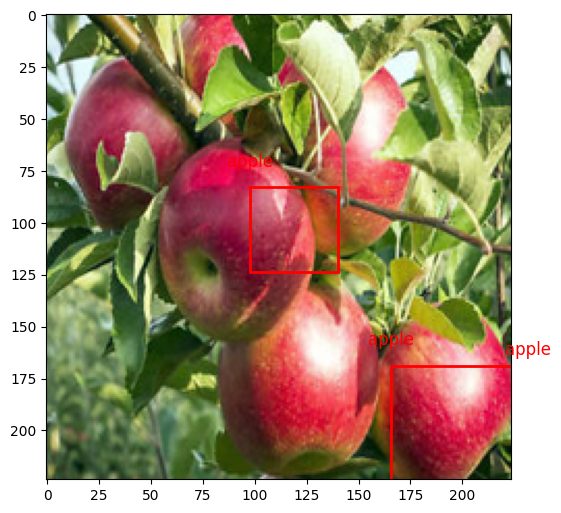

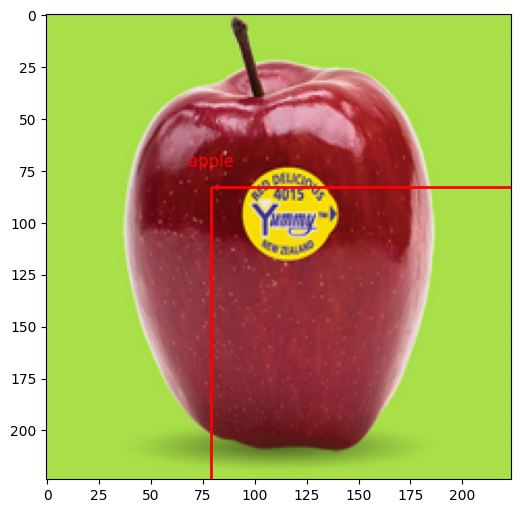

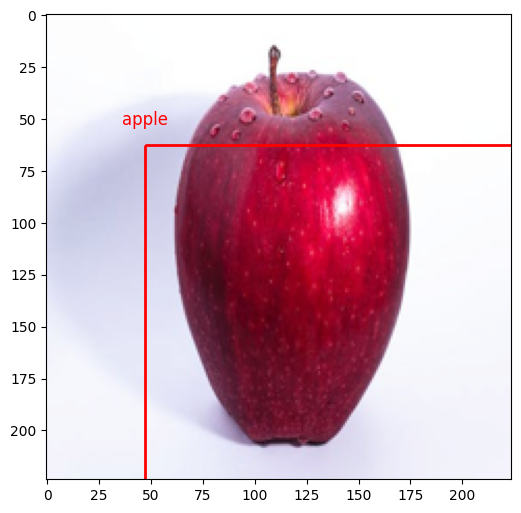

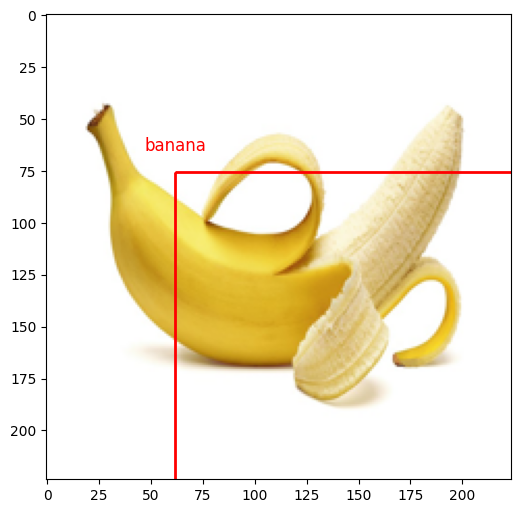

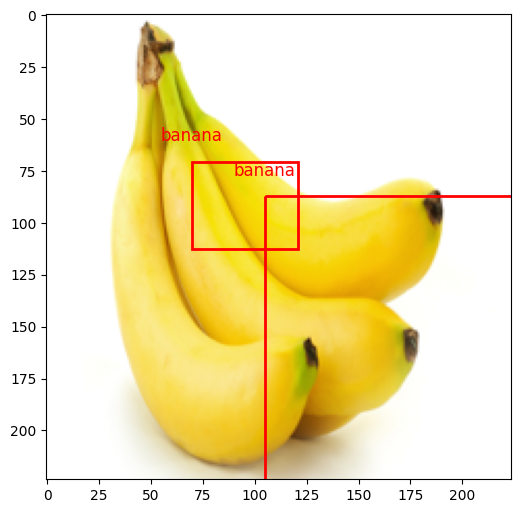

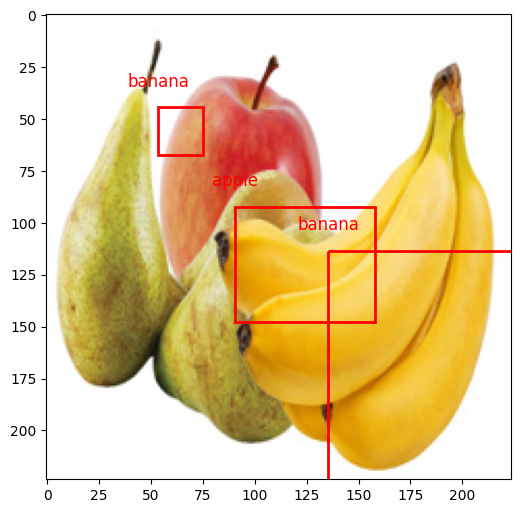

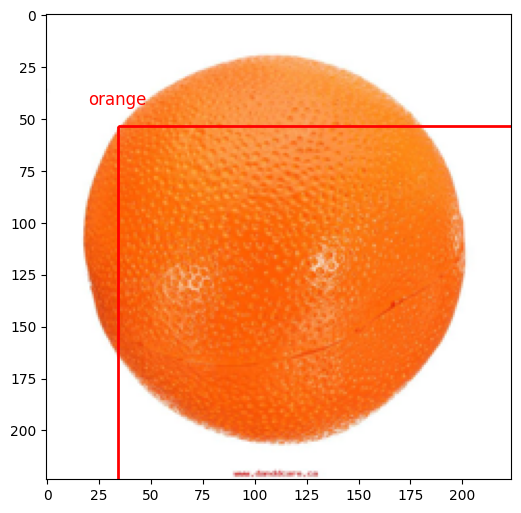

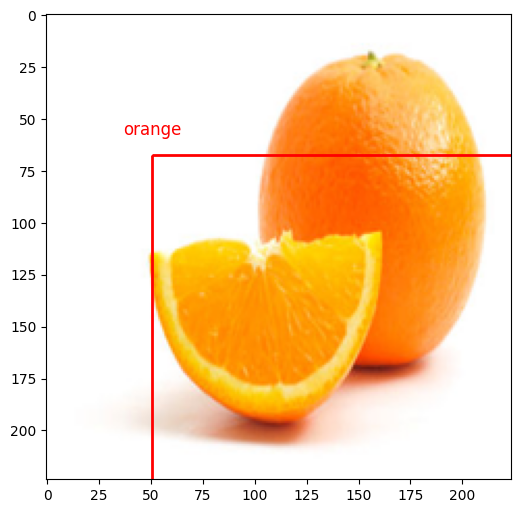

Test BBox Loss: 54.5035, Test Class Loss: 0.2030, Test Accuracy: 93.70%


In [1331]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_preds = []

test_dataset = FruitDataset(data_dir=config['data_test_dir'], df=test_df, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_bbox_loss = 0.0
test_class_loss = 0.0
correct_test_preds = 0
total_test_preds = 0

with torch.no_grad():
    for idx, (images, bboxes, labels) in enumerate(test_loader):
        images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)
        bbox_preds, class_preds = model(images)
        _, predicted_classes = torch.max(class_preds, 2)

        all_labels.extend(labels.view(-1).cpu().numpy())  # Flatten labels and convert to numpy
        all_preds.extend(predicted_classes.view(-1).cpu().numpy())  # Flatten predictions and convert to numpy
        
        for i in range(1):
            predicted_classes_for_image = predicted_classes[i].cpu().numpy()
            predicted_bboxes_for_image = bbox_preds[i].cpu().detach().numpy()
            plot_image(images[i], predicted_bboxes_for_image, predicted_classes_for_image)

        class_preds = class_preds.view(-1, num_classes)
        labels = labels.view(-1)

        bbox_loss = bbox_criterion(bbox_preds, bboxes)
        class_loss = class_criterion(class_preds, labels)
        
        test_bbox_loss += bbox_loss.item()
        test_class_loss += class_loss.item()

        _, predicted = torch.max(class_preds, 1)
        correct_test_preds += (predicted == labels).sum().item()
        total_test_preds += labels.size(0)

avg_test_bbox_loss = test_bbox_loss / len(test_loader)
avg_test_class_loss = test_class_loss / len(test_loader)
test_accuracy = 100 * correct_test_preds / total_test_preds

print(f"Test BBox Loss: {avg_test_bbox_loss:.4f}, Test Class Loss: {avg_test_class_loss:.4f}, "
      f"Test Accuracy: {test_accuracy:.2f}%")


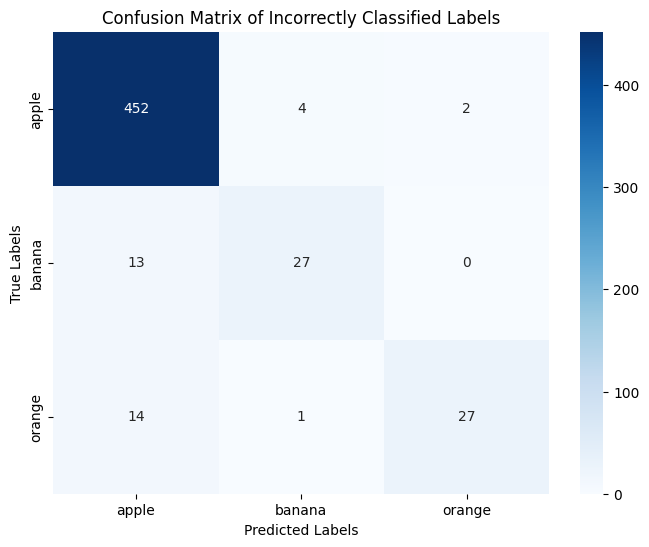

In [1324]:
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=config['class_mapping'], yticklabels=config['class_mapping'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Incorrectly Classified Labels')
plt.show()

<h3>Висновки:</h3>
<ul>
    <li>Модель з точністю 90% класифікує зображення на тестовому датасеті</li>
    <li>Проблема з точністю обирання bounding box повʼязана з невеликим датасетом</li>    
    <li>Обрано список гіперпараметрів: num_epochs, batch_size, learning_rate</li    
    <li>Після тюнингу гіперпараметрів вдалося несильно підвищити loss function for bounding box</li>>
    <li>
        Було обрано 2 функції втрат: 
        <ul>
            <li>для image classification - CrossEntropyLoss, бо він дає великі покарання за неправильно вгаданий клас і є класичним варіантом для цієї задачі.</ol>
            <li>Для обирання bounding box - Smooth L1 Loss, це гарний баланс між L1 loss та L2 loss, бо не ігнорує малих помилок (як L1 loss) та не дає завеликі покарання для великих помилок (як L2 loss). Використовується в інших моделях для object detection, таких як Faster R-CNN</ol>
        </ul>
    </li>
</ul>